In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import regex as re
from shutil import copyfile

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [28]:
image_path = "all_files"

image_size = (71, 71)
image_size_rgb = (71, 71)

batch_size = 32
seeds = 42

num_classes = 8

validation_s = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
train_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3179 files belonging to 8 classes.
Using 2544 files for training.
Found 3179 files belonging to 8 classes.
Using 635 files for validation.
Found 3179 files belonging to 8 classes.
Using 2544 files for training.
Found 3179 files belonging to 8 classes.
Using 635 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['10', '12', '1235', '15', '17', '2', '21', '38']


In [30]:
buffer_size = 32

train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)

train_ds_rgb = train_ds_rgb.prefetch(buffer_size=buffer_size)
val_ds_rgb = val_ds_rgb.prefetch(buffer_size=buffer_size)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


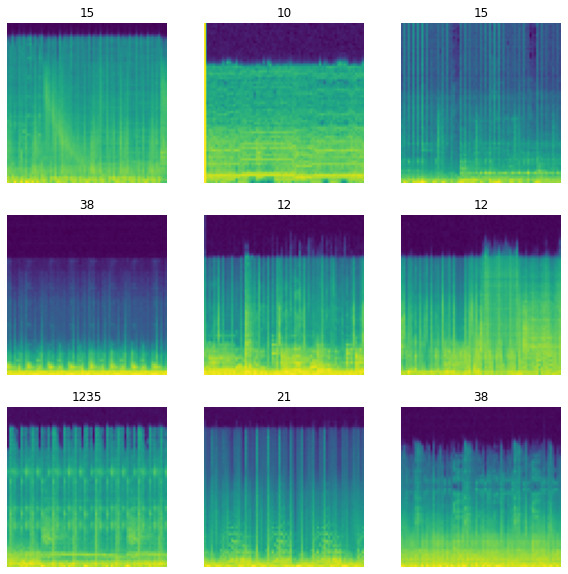

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
## Model parameters:
main_activation = "relu"
last_activation = "softmax"
bias = True
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = None
rescaling_layer = layers.Rescaling(scale=1.0 / 255)

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
normalization_layer = layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3))

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.35075948 0.9419944


In [36]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 71, 71, 1)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 71, 71, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 64)       

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
# epochs=20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [39]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(16, 3, padding='same', activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 71, 71, 1)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 71, 71, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 71, 71, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                      

In [40]:
model_bas.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
# epochs=20
# history = model_bas.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [50]:
epochs = 15
# l_r = 0.0005



def modell_fit_val(models,model_names,l_r = 0.001,chanels = 1):
    if chanels == 1:
        fit_train_ds = train_ds
        fit_val_ds = val_ds
    elif chanels == 3:
        fit_train_ds = train_ds_rgb
        fit_val_ds = val_ds_rgb

    #compile parameters

    models_test_acc = []
    for models, model_name in zip(models,model_names):
        
        opt = keras.optimizers.Adam(learning_rate=l_r)
        batch_size = 32
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        save_dir = "saves/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=4, min_delta=0.01,
            verbose=1
        )
        callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir + "_{epoch}.h5"),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        reducelr_callback]

        print("Training model: {} with learning rate: {}".format(model_name,l_r))

        models.compile(
            # optimizer=keras.optimizers.Adam(),
            optimizer=opt,
            loss=loss,
            metrics=["accuracy"]
        )
        models.fit(
            fit_train_ds, epochs=epochs, callbacks=callbacks, 
            validation_data=fit_val_ds, shuffle=True
        )
        test_loss, test_acc = models.evaluate(fit_val_ds, verbose=2)
        models_test_acc.append(test_acc)

    for counter, acc in enumerate(models_test_acc):
        print("the {}. model has an accuracyŰ of {}".format(counter,acc))

In [53]:
modell_fit_val([model,model_bas],["model","model_bas"],l_r=0.0001)

Training model: model with learning rate: 0.0001
Epoch 1/15
80/80 [==============================] - 9s 102ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9732 - lr: 1.0000e-04
Epoch 2/15
80/80 [==============================] - 6s 76ms/step - loss: 8.5677e-04 - accuracy: 1.0000 - val_loss: 0.1406 - val_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 3/15
80/80 [==============================] - 6s 77ms/step - loss: 7.4177e-04 - accuracy: 1.0000 - val_loss: 0.1493 - val_accuracy: 0.9748 - lr: 1.0000e-04
Epoch 4/15
80/80 [==============================] - 6s 76ms/step - loss: 6.7055e-04 - accuracy: 1.0000 - val_loss: 0.1455 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 5/15
80/80 [==============================] - ETA: 0s - loss: 6.0153e-04 - accuracy: 1.0000
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
80/80 [==============================] - 6s 76ms/step - loss: 6.0153e-04 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0

In [44]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units)(x)
    return keras.Model(inputs, outputs)


model_keras = make_model(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)

In [45]:
model_keras.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [46]:
# epochs=10
# history = model_keras.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [47]:
def make_model_im_net(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    inputs = layers.Rescaling(1.0 / 255)(inputs)

    input_shape_rgb = (input_shape[0], input_shape[1], 3)

    base_model = tf.keras.applications.Xception(input_shape = input_shape_rgb,
                                            include_top=False,
                                            weights='imagenet'
                                            
                                            )

    base_model.trainable = False

    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu", use_bias=True)(x)
    x = layers.Dense(64, activation="relu", use_bias=True)(x)
    outputs = layers.Dense(units)(x)
    return keras.Model(inputs,outputs)

model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)

In [48]:
model_im_net.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
# epochs=10
# history = model_im_net.fit(
#   train_ds_rgb,
#   validation_data=val_ds_rgb,
#   epochs=epochs)